# Save output

In [1]:
using Statistics
include("src-fig/plotting.jl")
foldername = "../scratch/turbulence-at-fronts/Strain-Larger"

save_all_slices(foldername)

143/601

LoadError: SYSTEM: show(lasterr) caused an error

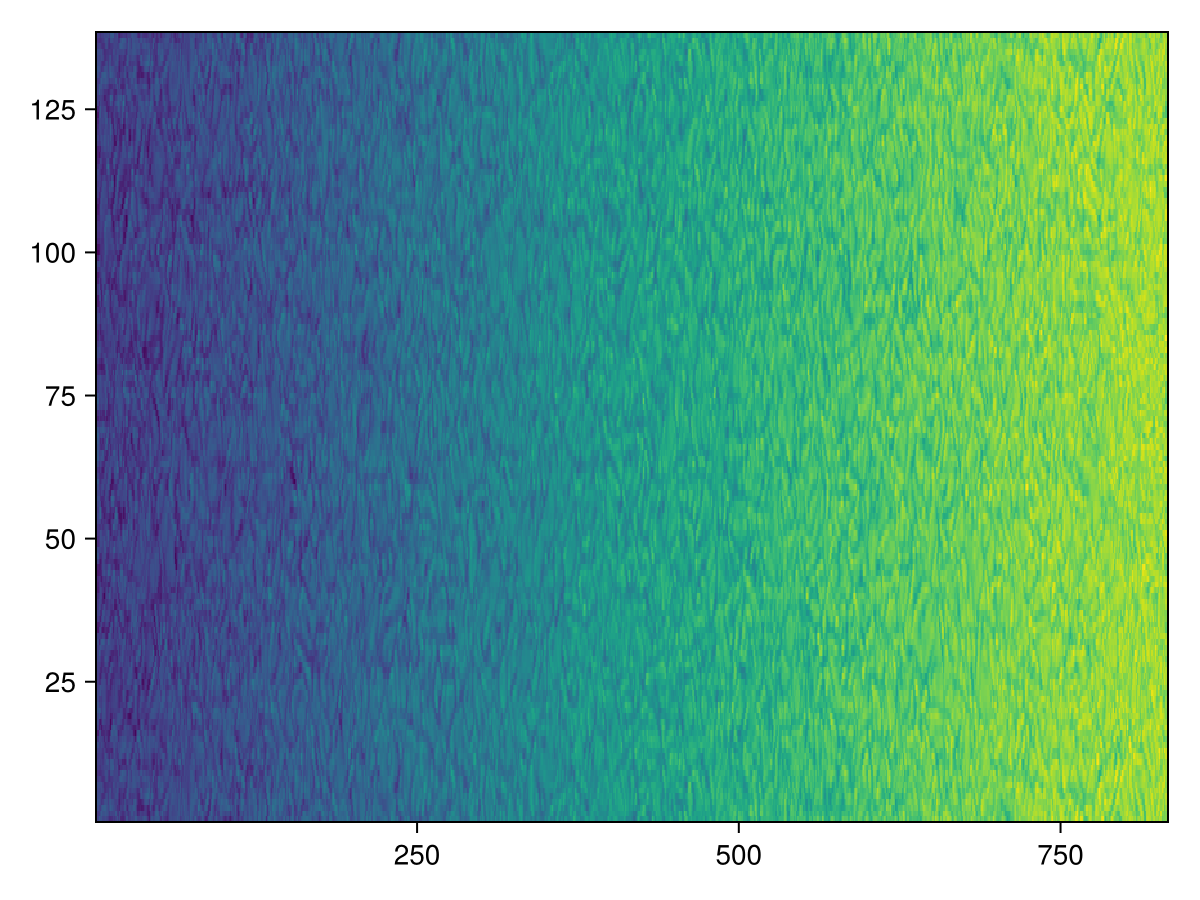

In [15]:
iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
filename = joinpath(foldername, "output.jld2")
Hx, Hy, Hz = jldopen(halos, filename)
inds = centre_indices(foldername)
using CairoMakie
heatmap(get_field(a->a[inds, :, Hx + sp.Nz + 1], filename, "b", iterations[401]; halo=true))

# 3D Schematic of the simulation

In [96]:
using Statistics
using GLMakie
using GLMakie.Colors
include("src-fig/plotting.jl")
foldername = "slices"

iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
xsᶜ, xsᶠ, ysᶜ, ysᶠ, zsᶜ, zsᶠ = grid_nodes(foldername)
inds = centre_indices(foldername)

#U = [-sp.\alpha * x for x in xs\^f, y in 1:1, z in 1:1]

u_top = get_field(joinpath(foldername, "u.jld2"), "top", iterations[1])
u_south = get_field(joinpath(foldername, "u.jld2"), "south", iterations[1])
u_west = get_field(joinpath(foldername, "u.jld2"), "west", iterations[1])

b_top = filt(get_field(joinpath(foldername, "b.jld2"), "top", iterations[1]), 1, 1)
b_south = filt(get_field(joinpath(foldername, "b.jld2"), "south", iterations[1]), 1, 0)
b_west = filt(get_field(joinpath(foldername, "b.jld2"), "west", iterations[1]), 1, 0)

fig = Figure()

ax = Axis3(fig[1, 1];
    limits = (-1.3sp.Lx/2000, 1.3sp.Lx/2000, -1.3sp.Ly/2000, 1.3sp.Ly/2000, -sp.Lz, sp.Lz/4),
    aspect = (1, 1, 1),
    xlabel=L"x/\text{km}",
    ylabel=L"y/\text{km}",
    zlabel=L"z/\text{m}",
    xticks=round.([-sp.Lx/2000, -sp.Lh/2000, sp.Lh/2000, sp.Lx/2000]; digits=2),
    yticks=round.([-sp.Ly/2000, sp.Ly/2000]; digits=2),
    zticks=[-sp.Lz, -sp.H, 0]
)

umax = mapreduce(max, [u_top, u_south, u_west]) do u
    maximum(abs, u)
end

colorrange = (-umax, umax)
cmap = to_colormap(:balance)

alpha_cmap = map(cmap) do c
    RGBA(c.r, c.g, c.b, 0.3)
end

# Plot the heatmap of u
heatmap!(ax, xsᶠ ./ 1000, ysᶜ ./ 1000, u_top; colorrange, colormap=cmap, transformation=(:xy, 0))
heatmap!(ax, xsᶠ ./ 1000, zsᶜ, u_south; colorrange, colormap=cmap, transformation=(:xz, ysᶜ[1] / 1000))
heatmap!(ax, ysᶜ ./ 1000, zsᶜ, u_west; colorrange, colormap=cmap, transformation=(:yz, -sp.Lx/2000))


# Represent the stretched xs with linesegments

# Plot the buoyancy contours
contour!(ax, xsᶜ ./ 1000, ysᶜ ./ 1000, b_top; linewidth=2, color=(:black, 1.0), transformation=(:xy, 0), levels=b_levels, fxaa=true)
contour!(ax, xsᶜ ./ 1000, zsᶜ, b_south; linewidth=2, color=(:black, 1.0), transformation=(:xz, ysᶜ[1] / 1000), levels=b_levels, fxaa=true)
contour!(ax, ysᶜ ./ 1000, zsᶜ, b_west; linewidth=2, color=(:black, 1.0), transformation=(:yz, -sp.Lx/2000), levels=b_levels, fxaa=true)


# Plot the next one?
for dy in []#[-4ysᶜ[1], -2ysᶜ[1], 2ysᶜ[1], 4ysᶜ[1]]
heatmap!(ax, xsᶠ ./ 1000, (dy .+ ysᶜ) ./ 1000, u_top; colorrange, colormap=alpha_colormap, transformation=(:xy, 0))
heatmap!(ax, xsᶠ ./ 1000, zsᶜ, u_south; colorrange, colormap=alpha_colormap, transformation=(:xz, (dy + ysᶜ[1]) / 1000))
heatmap!(ax, (dy .+ ysᶜ) ./ 1000, zsᶜ, u_west; colorrange, colormap=alpha_colormap, transformation=(:yz, -sp.Lh/2000))

contour!(ax, xsᶜ ./ 1000, (dy .+ ysᶜ) ./ 1000, b_top; color=(:black, 0.3), transformation=(:xy, 0), levels=b_levels, fxaa=true)
contour!(ax, xsᶜ ./ 1000, zsᶜ, b_south; color=(:black, 0.3), transformation=(:xz, (dy + ysᶜ[1]) / 1000), levels=b_levels, fxaa=true)
contour!(ax, (dy .+ ysᶜ) ./ 1000, zsᶜ, b_west; color=(:black, 0.3), transformation=(:yz, -sp.Lh/2000), levels=b_levels, fxaa=true)
end

# Plot some cooling stinklines
cooling_x = range(-sp.Lx/3000, sp.Lx/3000, 5)
cooling_y = range(-sp.Ly/3000, sp.Ly/3000, 3)
cooling_z = range(sp.Lz/8, sp.Lz / 4, 50)
@inline stinkline(z) = 0.02 * sin.(z + 0.1*rand()) + 0.02 * rand()
for x in cooling_x, y in cooling_y
    xs = x .+ stinkline.(cooling_z)
    ys = y .+ stinkline.(cooling_z)
    lines!(ax, xs, ys, cooling_z; color=(:red, 1.0))
end

# Plot some background flow arrows
arrows_x = range(-1.3sp.Lx/2000, 1.3sp.Lx/2000, 10)
arrows_y = range(-1.3sp.Ly/2000, 1.3sp.Ly/2000, 10)
arrows_z = [2sp.Lz / 8]

@inline U_func(p) = 0.3 * Point3(-p[1], p[2], 0) #./ sqrt(p[1]^2 + p[2]^2)

Ψ(x, y) = x * y
Ψ_levels = [Ψ(x, y) for x in arrows_x, y in arrows_y][:]

arrows3d!(ax, arrows_x, arrows_y, arrows_z, U_func; align=0.5, color=:green, tipradius=0.1)
#streamplot!(ax, U_func, xsᶜ ./ 1000, range(5ysᶜ[1], 5ysᶜ[end], 100) ./ 1000; arrow_size=40, linewidth=10, transformation=(:xy, arrows_z[1]), colormap=:grays)#, levels=Ψ_levels, color=:green)
fig

In [7]:
U_func(Point3(1, 1, 1))

3-element Point{3, Float64} with indices SOneTo(3):
 -0.7071067811865475
  0.7071067811865475
  0.0